# Tutorial Content


This notebook will walk you through steps to read in and organize velocity data in a raster format using xarray and rioxarray tools

First, lets install the python libraries that were listed on the [Software](software.ipynb) page:

In [1]:
import geopandas as gpd
import os
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube

In [2]:
!pwd

/Users/emarshall/Desktop/siparcs/xr_book1/mynewbook


In [3]:
gen_path = '/Users/emarshall/Desktop/siparcs/xr_book1/'

## ITS_LIVE (netcdf)

This section contains a workflow for reading in and organizing ITS_LIVE glacier velocity data that is accessed in netcdf format from the NSIDC DAAC. Whereas before, we needed to build a the magnitude of velocity variable from the velocity component variables (individual geotiff files), the netcdf file contains a variable for magnitude of velocity as well as many other variables representing land cover types, error estimates and metadata

In [11]:
itslive = rxr.open_rasterio(gen_path[:-9] + '/data/HMA_G0120_0000.nc').squeeze()

In [12]:
itslive

<xarray.Dataset>
Dimensions:         (y: 15904, x: 23440)
Coordinates:
  * y               (y) float64 1.643e+06 1.643e+06 ... -2.648e+05 -2.649e+05
  * x               (x) float64 -2.16e+06 -2.16e+06 ... 6.526e+05 6.527e+05
    band            int64 1
    UTM_Projection  int64 0
Data variables: (12/13)
    vx              (y, x) float32 ...
    chip_size_max   (y, x) uint16 ...
    ocean           (y, x) uint8 ...
    rock            (y, x) uint8 ...
    ice             (y, x) uint8 ...
    vy              (y, x) float32 ...
    ...              ...
    vx_err          (y, x) float32 ...
    vy_err          (y, x) float32 ...
    v_err           (y, x) float32 ...
    date            (y, x) float32 ...
    dt              (y, x) uint16 ...
    count           (y, x) uint16 ...
Attributes:
    author:                   Alex S. Gardner, JPL/NASA
    date_created:             08-May-2019 13:31:28
    GDAL_AREA_OR_POINT:       Area
    institution:              NASA Jet Propulsion Laboratory (JPL), Californi...
    motion_coordinates:       map
    motion_detection_method:  feature
    scene_pair_type:          optical
    title:                    autoRIFT surface velocities

What is the CRS of this object?

There are two ways we can check that. First, by using the `rio.crs` accessor:

In [13]:
itslive.rio.crs

CRS.from_wkt('PROJCS["Asia_North_Lambert_Conformal_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["false_easting",0],PARAMETER["false_northing",0],PARAMETER["central_meridian",95],PARAMETER["standard_parallel_1",15],PARAMETER["standard_parallel_2",65],PARAMETER["latitude_of_origin",30],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","102027"]]')

The netcdf object is in a different CRS than the geotiff object. Because **Asia North Lambert Conformal Conic** covers a larger spatial extent than a single UTM zone (the projection of the geotiff object), we will use that projection.
*add link to good explainer page?*

In [14]:
itslive.dims

Frozen({'y': 15904, 'x': 23440})

In [15]:
itslive.coords

Coordinates:
  * y               (y) float64 1.643e+06 1.643e+06 ... -2.648e+05 -2.649e+05
  * x               (x) float64 -2.16e+06 -2.16e+06 ... 6.526e+05 6.527e+05
    band            int64 1
    UTM_Projection  int64 0

## Vector data 

In [16]:
#read in vector data 
se_asia = gpd.read_file(gen_path[:-9] + 'data/nsidc0770_15.rgi60.SouthAsiaEast/15_rgi60_SouthAsiaEast.shp')

How many glaciers are in this dataframe?

In [17]:
len(se_asia['RGIId'])

13119

What coordinate reference system is this dataframe in? 

In [18]:
se_asia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The vector dataset is in WGS 84, meaning that its coordinates are in degrees latitude and longitude rather than meters N and E. We will project this dataset to match the projection of the netcdf dataset.

## Handling projections

Let's project this dataframe to match the CRS of the itslive dataset

In [19]:
#not sure why but this didn't work for me specifying epsg code, had to specify full description
se_asia_prj = se_asia.to_crs('+proj=lcc +lat_1=15 +lat_2=65 +lat_0=30 +lon_0=95 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m no_defs')
se_asia_prj

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-15.00001,G102044E29941N,19990920,-9999999,102.044042,29.941000,15,3,0.438,4996,...,251,850,0,0,0,0,9,9,None,"POLYGON ((626747.322 19334.286, 626747.214 193..."
1,RGI60-15.00002,G102042E29987N,19990920,-9999999,102.042346,29.987019,15,3,0.644,4947,...,244,1021,0,0,0,0,9,9,None,"POLYGON ((626699.144 24673.098, 626701.110 246..."
2,RGI60-15.00003,G102041E29997N,19990920,-9999999,102.041130,29.997311,15,3,0.225,5019,...,274,812,0,0,0,0,9,9,None,"POLYGON ((626205.858 25396.784, 626210.489 254..."
3,RGI60-15.00004,G102050E29962N,19990920,-9999999,102.050283,29.962297,15,3,0.985,4622,...,52,2318,0,0,0,0,9,9,None,"POLYGON ((627054.150 21582.052, 627057.905 216..."
4,RGI60-15.00005,G102044E30025N,19990920,-9999999,102.043728,30.025101,15,3,0.465,4733,...,20,913,0,0,0,0,9,9,None,"POLYGON ((626913.162 28267.766, 626895.820 282..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13114,RGI60-15.13115,G081977E30337N,20090918,-9999999,81.977000,30.337000,15,1,1.356,5480,...,352,1856,0,0,0,0,9,9,CN5Z342A0003,"POLYGON ((-1150121.533 121963.660, -1150118.27..."
13115,RGI60-15.13116,G081991E30339N,20090918,-9999999,81.991000,30.339000,15,1,7.427,5266,...,330,5779,0,0,0,0,9,9,CN5Z342A0003,"POLYGON ((-1148353.222 121707.808, -1148328.34..."
13116,RGI60-15.13117,G081355E30440N,20070912,-9999999,81.355000,30.440000,15,1,6.788,5696,...,96,5519,0,0,0,0,9,9,CN5Z342B0006,"POLYGON ((-1204224.276 142125.331, -1204220.83..."
13117,RGI60-15.13118,G081361E30451N,20070912,-9999999,81.361000,30.451000,15,1,0.043,5969,...,206,527,0,0,0,0,9,9,None,"POLYGON ((-1202593.561 141849.818, -1202579.07..."


## Let's start this analysis on a single glacier

We'll demonstrate analysis on a single glacier before scaling up to multiple glaciers. To start with, let's select the largest glacier in the dataframe.

In [31]:
se_asia_prj['Area'].idxmax()

11908

In [33]:
se_asia_prj.iloc[11908]

RGIId                                          RGI60-15.11909
GLIMSId                                        G096657E29334N
BgnDate                                              20050908
EndDate                                              -9999999
CenLon                                                 96.657
CenLat                                                 29.334
O1Region                                                   15
O2Region                                                    3
Area                                                  179.589
Zmin                                                     3980
Zmax                                                     6341
Zmed                                                     5207
Slope                                                    12.9
Aspect                                                     78
Lmax                                                    32403
Status                                                      0
Connect 

### So, our sample glacier is:

In [36]:
sample_glacier = se_asia_prj.loc[se_asia_prj['RGIId'] == 'RGI60-15.11909']
sample_glacier

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,RGI_int
11908,RGI60-15.11909,G096657E29334N,20050908,-9999999,96.657,29.334,15,3,179.589,3980,...,32403,0,0,1,0,1,9,Yagnung,"POLYGON ((141503.075 -60447.089, 141509.140 -6...",1511909


#### Clip raster data to vector (sample glacier)

We'll be following [this example](https://corteva.github.io/rioxarray/stable/examples/clip_geom.html), go check it out for more info  

In [37]:
itslive

<xarray.Dataset>
Dimensions:         (y: 15904, x: 23440)
Coordinates:
  * y               (y) float64 1.643e+06 1.643e+06 ... -2.648e+05 -2.649e+05
  * x               (x) float64 -2.16e+06 -2.16e+06 ... 6.526e+05 6.527e+05
    band            int64 1
    UTM_Projection  int64 0
Data variables: (12/13)
    vx              (y, x) float32 ...
    chip_size_max   (y, x) uint16 ...
    ocean           (y, x) uint8 ...
    rock            (y, x) uint8 ...
    ice             (y, x) uint8 ...
    vy              (y, x) float32 ...
    ...              ...
    vx_err          (y, x) float32 ...
    vy_err          (y, x) float32 ...
    v_err           (y, x) float32 ...
    date            (y, x) float32 ...
    dt              (y, x) uint16 ...
    count           (y, x) uint16 ...
Attributes:
    author:                   Alex S. Gardner, JPL/NASA
    date_created:             08-May-2019 13:31:28
    GDAL_AREA_OR_POINT:       Area
    institution:              NASA Jet Propulsion Laboratory (JPL), Californi...
    motion_coordinates:       map
    motion_detection_method:  feature
    scene_pair_type:          optical
    title:                    autoRIFT surface velocities

In [38]:
glacier_raster = itslive.rio.clip(sample_glacier.geometry, sample_glacier.crs)

In [39]:
glacier_raster

<xarray.Dataset>
Dimensions:         (y: 122, x: 226)
Coordinates:
  * y               (y) float64 -6.041e+04 -6.053e+04 ... -7.481e+04 -7.493e+04
  * x               (x) float64 1.357e+05 1.358e+05 ... 1.625e+05 1.627e+05
    band            int64 1
    spatial_ref     int64 0
    UTM_Projection  int64 0
Data variables: (12/13)
    vx              (y, x) float32 -3.277e+04 -3.277e+04 ... -3.277e+04
    chip_size_max   (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    ocean           (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    rock            (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    ice             (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    vy              (y, x) float32 -3.277e+04 -3.277e+04 ... -3.277e+04
    ...              ...
    vx_err          (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    vy_err          (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v_err           (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    date            (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dt              (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    count           (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    author:                   Alex S. Gardner, JPL/NASA
    date_created:             08-May-2019 13:31:28
    GDAL_AREA_OR_POINT:       Area
    institution:              NASA Jet Propulsion Laboratory (JPL), Californi...
    motion_coordinates:       map
    motion_detection_method:  feature
    scene_pair_type:          optical
    title:                    autoRIFT surface velocities

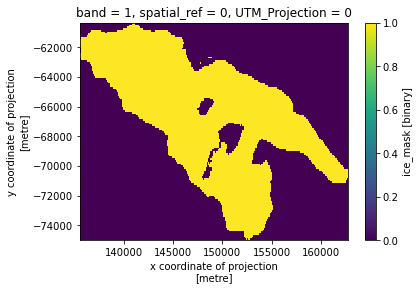

In [52]:
glacier_raster.ice.plot()

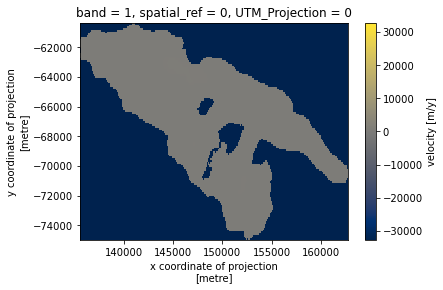

In [56]:
fig, ax = plt.subplots()

#sample_glacier.plot(ax=ax, facecolor='white', edgecolor='red')
glacier_raster.v.plot(ax=ax, cmap=plt.cm.cividis)

In [57]:
glacier_raster.v.data.min()

-32767.0

### Handling missing data / selecting data (xr.where)
The above plot isn't that informative because you can see that the non-glaciated terrain surrounding the glacier is assigned negative values that skew the colorscale. Assigning missing or non-target datapoints a unique and distinctive numeric value can be useful in some cases, but for our purposes we don't want them showing up in our plots right now.

In [88]:
#anywhere glacier_raster.ice == 0, we want to turn to nan (I think?)
glacier_raster_x = xr.where(glacier_raster.ice != 0., glacier_raster, np.nan)

In [81]:
np.count_nonzero(~np.isnan(glacier_raster_x.ice.data))

0

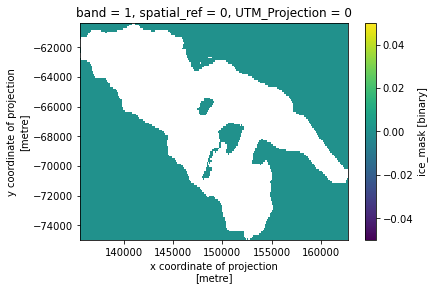

In [91]:
glacier_raster.ice.plot()